## Story 5

### Instructions
Historic data indicates that the occurrence and intensity of cyclonic storms (Hurricanes, Typhoons and Tornados) increases with the increased earth temperature. For this assignment you will need to tell this story to a non-technical audience (eg: a high-school earth science class).

### Notes:
- Source historic data for a period of at least 25 years on a measure of the earth's temperature.
- Source data on the occurrence and intensity of hurricanes, typhoons and tornados for the same historic period.
- Perform the data analysis to establish the correlations between earth temperature and storm occurrence and intensity.
- Tell the story of this data and your analysis using data visualizations and other illustrations (eg: pictures of storm damage) in a presentation that will be accessible to a high-school earth science class.
- This assignment is due at the end of the week ten of the semester.

In [296]:
import pandas as pd
import requests
import re
import viz_lib as vl
import matplotlib.pyplot as plt
import statsmodels.api as sm
from functools import reduce
from datetime import datetime
import os
import json
import numpy as np

In [2]:
### Establishing Environmental Credentials
home_directory = os.path.expanduser("~")
cred_file = os.path.join(home_directory , 'my_creds.json')
with open(cred_file, 'r') as f:
    creds = json.load(f)
api_key = creds['NOAA']["token"]

### Pulling in Global Temp Anomaly Data From NOAA

In [273]:
url = "https://www.ncei.noaa.gov/data/noaa-global-surface-temperature/v6/access/timeseries/aravg.ann.land.00N.30N.v6.0.0.202508.asc"

# Column meanings from the metadata (https://www.ncei.noaa.gov/data/noaa-global-surface-temperature/v6/access/timeseries/00_Readme_timeseries.txt)
col_names = ["year", "anom_C", # temp anomaly (K, same numeric as °C for anomalies)
    "errvar_total_K2","errvar_highfreq_K2", "errvar_lowfreq_K2","errvar_bias_K2" ]
# Read the whitespace-separated file, treat -999 as missing
df = pd.read_csv(url,delim_whitespace=True,header=None,names=col_names,na_values=-999.0)
df = df[["year", "anom_C"]].copy()
print(df.head())

# #Make a line chart of temperature anomaly over time
# plt.figure(figsize=(10, 5))
# plt.plot(df["year"], df["anom_C"], marker="o", linewidth=1)

# plt.xlabel("Year")
# plt.ylabel("Temperature anomaly (°C)")
# plt.title("Annual Land Temperature Anomaly (0–30°N)")
# plt.grid(True)
# plt.tight_layout()
# plt.show()

C:\Users\johnf\AppData\Local\Temp\ipykernel_25332\3535386862.py:7: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(url,delim_whitespace=True,header=None,names=col_names,na_values=-999.0)


   year    anom_C
0  1850 -0.669086
1  1851 -0.578691
2  1852 -0.300785
3  1853 -0.446708
4  1854 -0.602077


In [31]:
## Smothing thie data with a moving average for simplicity sake. 
# 10-year centered moving average of the anomaly
df["anom_C_ma10"] = df["anom_C"].rolling(window=10, center=True).mean()
df["anom_C_ma5"] = df["anom_C"].rolling(window=5, center=True).mean()

### Pulling in Historic Storm Data 

In [131]:
base_dir = "https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/"
index_html = requests.get(base_dir).text
matches = re.findall( r"StormEvents_details-ftp_v1\.0_d(\d{4})_c(\d{8})\.csv\.gz", index_html)

year_to_url = {int(year): base_dir + f"StormEvents_details-ftp_v1.0_d{year}_c{created}.csv.gz" for year, created in matches}

start_year, end_year = 1950, 2020  # change as needed
frames = []

for year in range(start_year, end_year + 1):
    url = year_to_url.get(year)
    if not url:
        print(f"No details file for {year}, skipping")
        continue

    print("Loading:", url)
    df_y = pd.read_csv(url, compression="gzip", low_memory=False)

    # Keep only columns relevant to deaths, injuries, damage, etc.
    cols = [
        "YEAR", "MONTH_NAME", "STATE", "EVENT_TYPE",
        "DEATHS_DIRECT", "DEATHS_INDIRECT",
        "INJURIES_DIRECT", "INJURIES_INDIRECT",
        "DAMAGE_PROPERTY", "DAMAGE_CROPS",
    ]
    df_y = df_y[cols]
    frames.append(df_y)

df_damage = pd.concat(frames, ignore_index=True)

Loading: https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d1950_c20250520.csv.gz
Loading: https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d1951_c20250520.csv.gz
Loading: https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d1952_c20250520.csv.gz
Loading: https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d1953_c20250520.csv.gz
Loading: https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d1954_c20250520.csv.gz
Loading: https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d1955_c20250520.csv.gz
Loading: https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d1956_c20250520.csv.gz
Loading: https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d1957_c20250520.csv.gz
Loading: https://www.nce

In [195]:
## Processing storm intensity data
df_damage["deaths_total"] = ( df_damage["DEATHS_DIRECT"].fillna(0) + df_damage["DEATHS_INDIRECT"].fillna(0))
df_damage["injuries_total"] = ( df_damage["INJURIES_DIRECT"].fillna(0) +  df_damage["INJURIES_INDIRECT"].fillna(0))

def parse_damage(val):
    """Convert NOAA damage strings like '25K','2.3M','1.0B' to numeric dollars."""
    if pd.isna(val):
        return 0.0
    s = str(val).strip()
    if s == "" or s == "0":
        return 0.0

    multipliers = {"K": 1e3, "M": 1e6, "B": 1e9}
    last = s[-1]
    if last in multipliers:
        num_part = s[:-1]
        try:
            return float(num_part) * multipliers[last]
        except ValueError:
            return 0.0
    try:
        return float(s)
    except ValueError:
        return 0.0

df_damage["damage_property_usd"] = df_damage["DAMAGE_PROPERTY"].apply(parse_damage)
df_damage["damage_crops_usd"] = df_damage["DAMAGE_CROPS"].apply(parse_damage)
df_damage["damage_total_usd"] = ( df_damage["damage_property_usd"] + df_damage["damage_crops_usd"])
# Yearly totals by event type
yearly = (
    df_damage
    .groupby(["YEAR", "EVENT_TYPE"], as_index=False)
    .agg(
        num_events=("EVENT_TYPE", "size"),
        deaths_total=("deaths_total", "sum"),
        injuries_total=("injuries_total", "sum"),
        damage_property_usd=("damage_property_usd", "sum"),
        damage_total_usd=("damage_total_usd", "sum"),
    )
    .sort_values(["YEAR", "EVENT_TYPE"])
)
for c in ["num_events", "deaths_total", "injuries_total"]:
    yearly[c] = yearly[c].astype(int)

# # If you only want injuries + total damage, keep just those:
# yearly_min = yearly[["YEAR", "EVENT_TYPE", "num_events", "injuries_total", "damage_total_usd"]]
# storms = yearly_min[yearly_min['EVENT_TYPE'].isin(['Tornado','Hurricane (Typhoon)','Marine Hurricane/Typhoon', 'Marine Tropical Storm','Tropical Storm'])]
# storms["storm type"] = None
# storms["storm type"][storms["EVENT_TYPE"].astype(str).str.lower().str.contains('hurricane')] = 'Hurricane / Typhoon'
# storms["storm type"][storms["EVENT_TYPE"].astype(str).str.lower().str.contains('tropical storm')] = 'Tropical Storm'
# storms["storm type"][storms["EVENT_TYPE"].astype(str).str.lower().str.contains('tornado')] = 'Tornado'
# storms= storms.rename(columns={"YEAR":"year",         
#                        "num_events":"count of events",
#                        "injuries_total":"total injuries",
#                        "damage_total_usd":"total damage usd"})
# storms_lim = storms[['year','storm type', 'count of events', 'total injuries', 'total damage usd']]

In [196]:
want_types = ["Tornado", "Hurricane (Typhoon)", "Tropical Storm"]
y = yearly.copy()
y["EVENT_TYPE"] = y["EVENT_TYPE"].str.strip()

def norm_type(s):
    s = str(s).lower()
    if "torn" in s: return "Tornado"
    if "hurr" in s or "typh" in s: return "Hurricane (Typhoon)"
    if "tropical" in s: return "Tropical Storm"
    return s.title()
y["EVENT_TYPE"] = y["EVENT_TYPE"].apply(norm_type)
y = y[y["EVENT_TYPE"].isin(want_types)]
wide = (y.pivot_table(index="YEAR",  columns="EVENT_TYPE",  values=["num_events", "injuries_total", "damage_total_usd"],aggfunc="sum",).sort_index())

# 2) Flatten MultiIndex columns -> metric_stormtype (clean names)
def clean_type(t):
    return (
        t.lower()
        .replace(" ", "_")
        .replace("(", "")
        .replace(")", "")
    )

wide.columns = [f"{m}_{clean_type(t)}" for m, t in wide.columns]
wide = wide.fillna(0)
int_cols = [c for c in wide.columns if c.startswith("num_events_") or c.startswith("injuries_total_")]
wide[int_cols] = wide[int_cols].astype(int)
wide.index.name = None

# print(wide.head(10))
# keep your existing setup
lim_1990 = wide[wide['year'] >= 1990]
dfw = lim_1990.copy()
if "year" in dfw.columns:
    dfw = dfw.set_index("year")
dfw = dfw.sort_index()

# ----- 5-year moving averages for every numeric column -----
for col in dfw.select_dtypes(include="number").columns:
    dfw[col + "_ma5"] = dfw[col].rolling(window=5, center=True, min_periods=1).mean()

# ----- Column mapping for readability (original columns) -----
count_cols = {"Tornadoes": "num_events_tornado","Hurricanes/Typhoons": "num_events_hurricane_typhoon","Tropical storms": "num_events_tropical_storm"}
inj_cols = {    "Tornadoes": "injuries_total_tornado","Hurricanes/Typhoons": "injuries_total_hurricane_typhoon",
            "Tropical storms": "injuries_total_tropical_storm",}
dam_cols = {    "Tornadoes": "damage_total_usd_tornado",    "Hurricanes/Typhoons": "damage_total_usd_hurricane_typhoon",
    "Tropical storms": "damage_total_usd_tropical_storm",}


      damage_total_usd_hurricane_typhoon  damage_total_usd_tornado  \
1950                                 0.0                34481650.0   
1951                                 0.0                65505990.0   
1952                                 0.0                94302240.0   
1953                                 0.0               596104700.0   
1954                                 0.0                85805320.0   
1955                                 0.0                82660630.0   
1956                                 0.0               116912350.0   
1957                                 0.0               224388890.0   
1958                                 0.0               128994610.0   
1959                                 0.0                87453040.0   

      damage_total_usd_tropical_storm  injuries_total_hurricane_typhoon  \
1950                              0.0                                 0   
1951                              0.0                                 0   
1952

In [215]:
### Merging data 
# all_ = df.merge(dfw,how='left',on='year')
# for col in ["num_tornado", "num_hurr_typhoon", "num_tropical_storm"]:
#     all_[col + "_ma5"] = all_[col].rolling(window=5, center=True).mean()

# # Drop years at the ends where the 5-year MA is NaN
# plot_df = all_.dropna(
#     subset=["anom_C_ma5", "num_tornado_ma5", "num_hurr_typhoon_ma5", "num_tropical_storm_ma5"]
# )

In [216]:
# all_

,year,anom_C,anom_C_ma10,anom_C_ma5,damage_total_usd_hurricane_typhoon,damage_total_usd_tornado,damage_total_usd_tropical_storm,injuries_total_hurricane_typhoon,injuries_total_tornado,injuries_total_tropical_storm,...,num_events_tropical_storm,damage_total_usd_hurricane_typhoon_ma5,damage_total_usd_tornado_ma5,damage_total_usd_tropical_storm_ma5,injuries_total_hurricane_typhoon_ma5,injuries_total_tornado_ma5,injuries_total_tropical_storm_ma5,num_events_hurricane_typhoon_ma5,num_events_tornado_ma5,num_events_tropical_storm_ma5
0,1850,-0.669086,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1851,-0.578691,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1852,-0.300785,NaN,-0.519469,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1853,-0.446708,NaN,-0.493724,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1854,-0.602077,NaN,-0.540513,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,2021,1.121201,1.061691,1.042366,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
172,2022,0.815964,NaN,1.133360,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
173,2023,1.301357,NaN,1.144151,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
174,2024,1.419959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
all_

### Viz # 1 - Temperature Anomoly over time (HS Class Level)

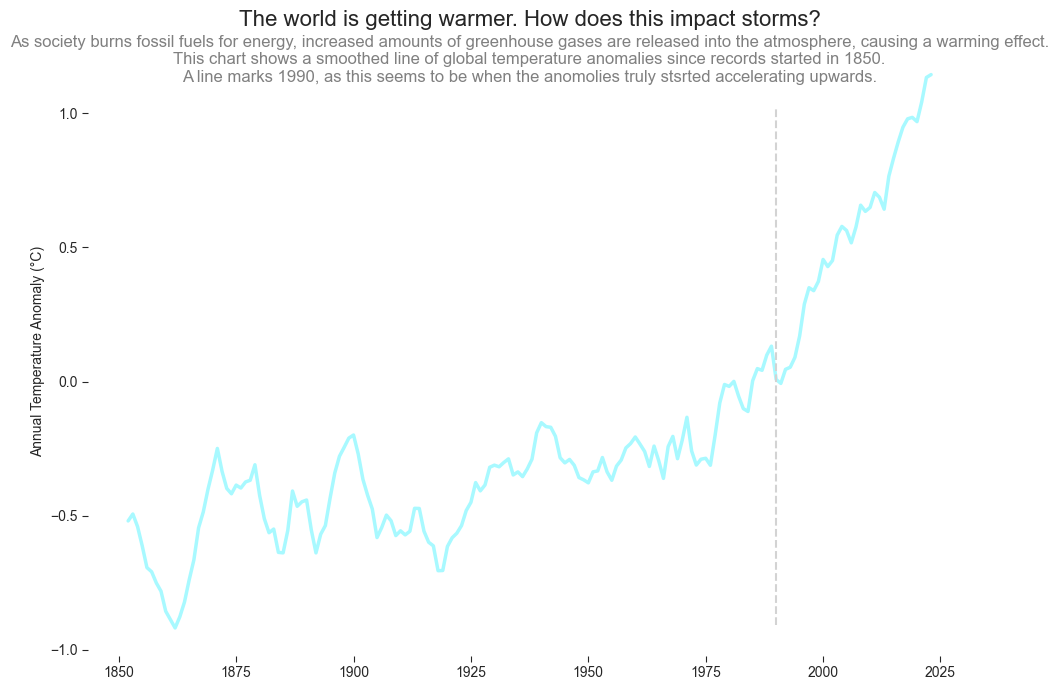

In [339]:
fig, ax = plt.subplots(figsize=(11, 7))

# smoothed anomaly (highlight) – adjust column name if needed
ax.plot(all_["year"], all_["anom_C_ma5"], color="#A8F9FF",linewidth=2.5, label="5-year moving average")

# No x-axis label
ax.set_xlabel("")
ax.set_ylabel("Annual Temperature Anomaly (°C)")

# Bigger title + extra padding
ax.set_title(
    "The world is getting warmer. How does this impact storms?",
    fontsize=16,          # <- bigger title
    pad=15                # <- pushes plot down, leaving room for text
)

# Subtitle (shifted down, anchored from the TOP so it flows downward)
subtitle = (
    "As society burns fossil fuels for energy, increased amounts of greenhouse gases are "
    "released into the atmosphere, causing a warming effect.\n"
    "This chart shows a smoothed line of global temperature anomalies since records started in 1850.\n"
    "A line marks 1990, as this seems to be when the anomolies truly stsrted accelerating upwards."
)

ax.text(
    0.5, 1.02,            # slightly below the very top of the axes
    subtitle,
    transform=ax.transAxes,
    ha="center",
    va="top",             # anchor the TOP of the text at y=1.02 so it flows downward
    fontsize=12,
    color="gray",
)

# === vertical reference line at 1990 ===
ax.axvline(
    x=1990,
    color="lightgray",
    linewidth=1.5,
    linestyle="--",
    ymin=0.05,  # 5% above bottom of plot
    ymax=0.90,  # 10% below top of plot so it doesn't hit the text
)


# Turn off grid lines
ax.grid(False)

# Minimalist axes
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)   # hide x-axis line
ax.spines["left"].set_visible(False)
ax.tick_params(axis="both", length=4, width=0.8)

# Legend bottom right
# ax.legend(frameon=False, loc="lower right")

fig.tight_layout()
plt.show()


In [340]:
# # Size your figure to fit a 16:9 slide nicely (13.33" × 7.5" ~ 1920×1080 at 144 dpi)
fig.set_size_inches(13.33, 7.5)  # optional but helpful

# # Solid white background (best for PPT)
fig.savefig("Story5_Viz1.png", dpi=300, bbox_inches="tight", transparent=True)  #facecolor="white",

### Viz 2 - Number of storms by type since 1990, when the temperature really began to drasitcally increase.


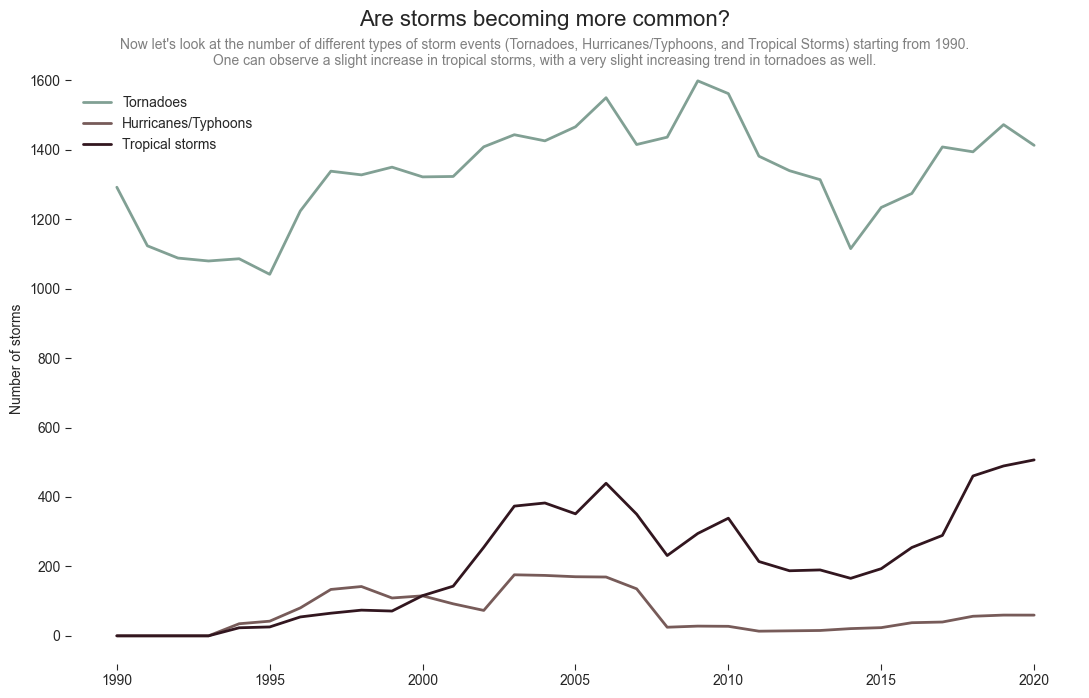

In [341]:
fig, ax = plt.subplots(figsize=(11, 7))
palette = {"Tornadoes": "#81A094", "Hurricanes/Typhoons": "#775B59", "Tropical storms": "#32161F"}
count_cols = {
    "Tornadoes": "num_events_tornado",
    "Hurricanes/Typhoons": "num_events_hurricane_typhoon",
    "Tropical storms": "num_events_tropical_storm",
}

# plot (5-yr avg or raw—your choice)
for label, base_col in count_cols.items():
    col = base_col + "_ma5"   # use base_col for raw
    if col in dfw.columns:
        ax.plot(dfw.index, dfw[col], linewidth=2, label=f"{label}",# (5-yr avg)
                color=palette.get(label, "#333333"))

# --- title + subtitle in FIGURE space ---
title = "Are storms becoming more common?"
subtitle = (
    "Now let's look at the number of different types of storm events (Tornadoes, "
    "Hurricanes/Typhoons, and Tropical Storms) starting from 1990.\n"
    "One can observe a slight increase in tropical storms, with a very slight increasing trend in tornadoes as well."
)

# give the top extra room for title/subtitle
fig.subplots_adjust(top=0.9)      # tweak 0.74–0.82 as needed
fig.suptitle(title, fontsize=16, y=0.99)
fig.text(0.5, 0.95, subtitle, ha="center", va="top", fontsize=10, color="gray")

# minimalist axes
ax.set_xlabel("")
ax.set_ylabel("Number of storms")
ax.grid(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.tick_params(axis="both", length=4, width=0.8)

# legend safely below the subtitle (inside axes)
ax.legend(frameon=False, loc="upper left", bbox_to_anchor=(0, 0.95)) 

fig.tight_layout()
plt.show()


In [342]:
# # Size your figure to fit a 16:9 slide nicely (13.33" × 7.5" ~ 1920×1080 at 144 dpi)
fig.set_size_inches(13.33, 7.5)  # optional but helpful

# # Solid white background (best for PPT)
fig.savefig("Story5_Viz2.png", dpi=300, bbox_inches="tight", transparent=True) #, facecolor="white"

## Viz 3 - Line Chart showing Trend for Damages

In [316]:
dfw.columns

Index(['damage_total_usd_hurricane_typhoon', 'damage_total_usd_tornado',
       'damage_total_usd_tropical_storm', 'injuries_total_hurricane_typhoon',
       'injuries_total_tornado', 'injuries_total_tropical_storm',
       'num_events_hurricane_typhoon', 'num_events_tornado',
       'num_events_tropical_storm', 'damage_total_usd_hurricane_typhoon_ma5',
       'damage_total_usd_tornado_ma5', 'damage_total_usd_tropical_storm_ma5',
       'injuries_total_hurricane_typhoon_ma5', 'injuries_total_tornado_ma5',
       'injuries_total_tropical_storm_ma5', 'num_events_hurricane_typhoon_ma5',
       'num_events_tornado_ma5', 'num_events_tropical_storm_ma5'],
      dtype='object')

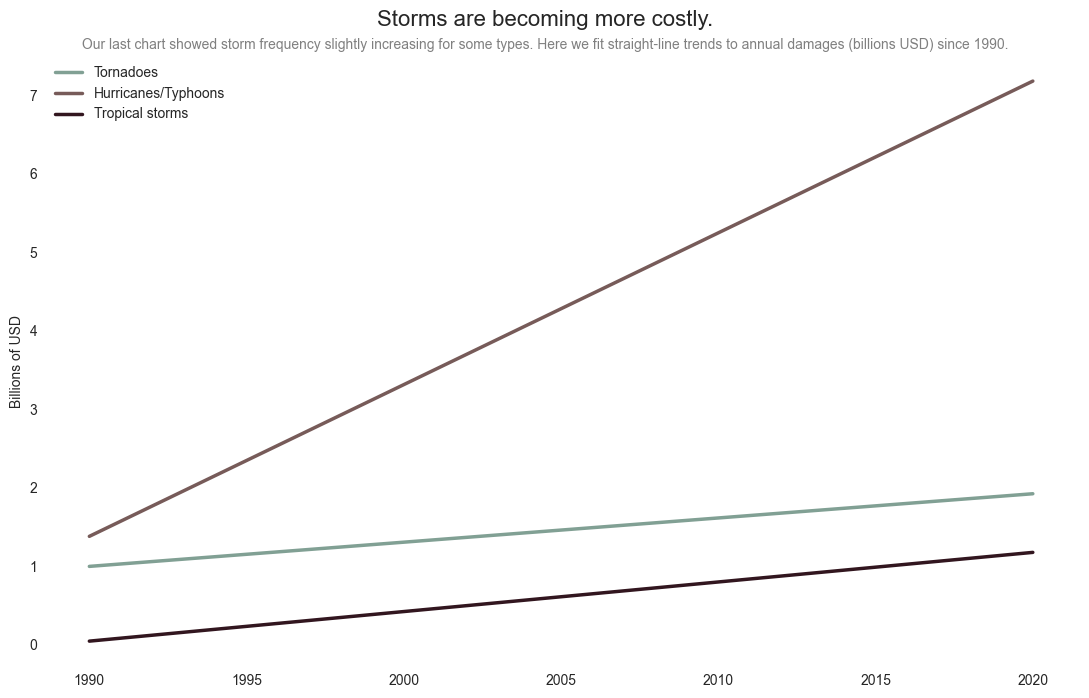

In [343]:
import numpy as np
import matplotlib.pyplot as plt

# --- damage columns in your wide df (raw annual series) ---
damage_cols = {
    "Tornadoes": "damage_total_usd_tornado",
    "Hurricanes/Typhoons": "damage_total_usd_hurricane_typhoon",
    "Tropical storms": "damage_total_usd_tropical_storm",
}
present = {lbl: col for lbl, col in damage_cols.items() if col in dfw.columns}

# Prep annual frame (1990+ window; adjust as needed)
df = dfw.copy()
if "year" in df.columns:
    df = df.set_index("year")
df.index = df.index.astype(int)
df = df.sort_index().loc[df.index >= 1990]

years = df.index.values.astype(float)

# --- trendlines from RAW annual data (billions USD) ---
fig, ax = plt.subplots(figsize=(11, 7))
palette = {"Tornadoes": "#81A094", "Hurricanes/Typhoons": "#775B59", "Tropical storms": "#32161F"}

for label, col in present.items():
    y = (df[col].astype(float) / 1e9).replace([np.inf, -np.inf], np.nan).dropna()
    x = y.index.astype(float)
    if len(x) >= 2 and np.any(y.values):
        m, b = np.polyfit(x, y.values, 1)
        ax.plot(years, m * years + b, linewidth=2.5, label=label, color=palette.get(label, "#555"))

title = "Storms are becoming more costly."
subtitle = (
    "Our last chart showed storm frequency slightly increasing for some types. "
    "Here we fit straight-line trends to annual damages (billions USD) since 1990."
)
# Titles (figure space)
fig.subplots_adjust(top=0.9)      # tweak 0.74–0.82 as needed
fig.suptitle(title, fontsize=16, y=0.99)
fig.text(0.5, 0.95, subtitle, ha="center", va="top", fontsize=10, color="gray")


# Labels + minimalist styling (no axis lines)
ax.set_xlabel("")                    # no "Year"
ax.set_ylabel("Billions of USD")
ax.grid(False)
for side in ("top", "right", "bottom", "left"):
    ax.spines[side].set_visible(False)   # remove axis lines
ax.tick_params(axis="both", length=0, width=0.0)  # hide tick marks (keep labels)

ax.legend(frameon=False, loc="upper left")
fig.tight_layout()
plt.show()


In [344]:
# # Size your figure to fit a 16:9 slide nicely (13.33" × 7.5" ~ 1920×1080 at 144 dpi)
fig.set_size_inches(13.33, 7.5)  # optional but helpful

# # Solid white background (best for PPT)
fig.savefig("Story5_Viz3.png", dpi=300, bbox_inches="tight", transparent=True) # facecolor="white"

In [ ]:
Viz 4  - Concluding Graphioc 

Slope: 513.02 storms per +1°C
p-value: 0.0737
R²: 0.106


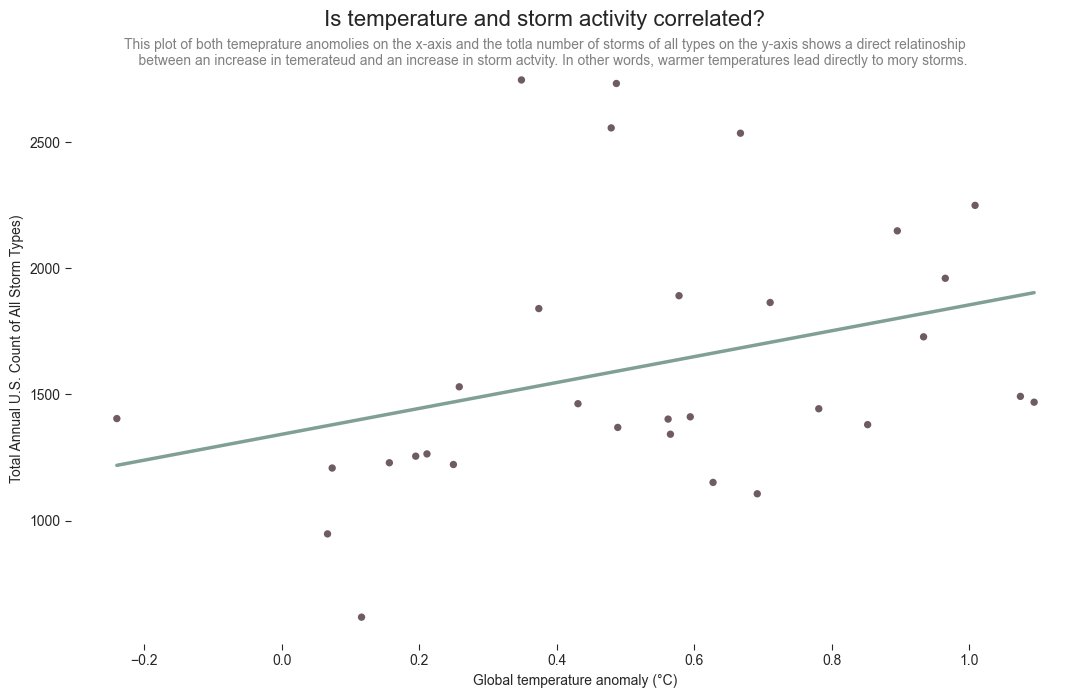

In [346]:
counts = dfw.copy()
if "year" in counts.columns:
    counts = counts.set_index("year")
counts = counts.sort_index()
count_cols = [c for c in counts.columns if c in ["num_events_tornado","num_events_hurricane_typhoon","num_events_tropical_storm"]]
counts["total_storms"] = counts[count_cols].sum(axis=1)
temps = all_.loc[:, ["year", "anom_C"]].set_index("year").sort_index()
df = (counts.loc[:, ["total_storms"]].join(temps, how="inner").loc[lambda d: d.index >= 1990].dropna())

# Fit regression: total_storms ~ anomaly (linear) ---
X = sm.add_constant(df["anom_C"].values)       # [const, anomaly]
y = df["total_storms"].values.astype(float)
model = sm.OLS(y, X).fit()

slope = model.params[1]         # storms per +1 °C anomaly
pval  = model.pvalues[1]
r2    = model.rsquared

print(f"Slope: {slope:.2f} storms per +1°C")
print(f"p-value: {pval:.4f}")
print(f"R²: {r2:.3f}")

# --- 5) Plot: scatter + fitted line (minimalist) ---
x = df["anom_C"].values
x_line = np.linspace(x.min(), x.max(), 200)
y_line = model.params[0] + model.params[1] * x_line

fig, ax = plt.subplots(figsize=(11, 7))

ax.scatter(x, y, s=28, alpha=0.7, edgecolor="none",color="#32161F")            # points
ax.plot(x_line, y_line, linewidth=2.5, color="#81A094")        # regression line

title = "Is temperature and storm activity correlated?"
subtitle = (
    """This plot of both temeprature anomolies on the x-axis and the totla number of storms of all types on the y-axis shows a direct relatinoship
    between an increase in temerateud and an increase in storm actvity. In other words, warmer temperatures lead directly to mory storms."""
)
# Titles (figure space)
fig.subplots_adjust(top=0.9)      # tweak 0.74–0.82 as needed
fig.suptitle(title, fontsize=16, y=0.99)
fig.text(0.5, 0.95, subtitle, ha="center", va="top", fontsize=10, color="gray")# Storm events vs. global temperature anomaly (since 1990)

ax.set_xlabel("Global temperature anomaly (°C)")
ax.set_ylabel("Total Annual U.S. Count of All Storm Types)")

# Minimalist style
ax.grid(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.tick_params(axis="both", length=4, width=0.8)

# Small annotation with stats
# ax.text(
#     0.02, 0.98,
#     f"Slope: {slope:.1f} storms/°C\np={pval:.3g}, R²={r2:.2f}",
#     transform=ax.transAxes, ha="left", va="top", fontsize=10, color="gray"
# )

fig.tight_layout()
plt.show()


In [347]:
# # Size your figure to fit a 16:9 slide nicely (13.33" × 7.5" ~ 1920×1080 at 144 dpi)
fig.set_size_inches(13.33, 7.5)  # optional but helpful

# # Solid white background (best for PPT)
fig.savefig("Story5_Viz4.png", dpi=300, bbox_inches="tight", transparent=True) # facecolor="white"